In [62]:
from library.cVAE import GCN_Encoder, GRU_Decoder, cVAE
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import  Subset
from library.GCN import GraphData
from library.cVAE_helper import (
    make_stratified_bins,
    get_dataloader,
    smiles_to_idxs,
    loss_function,
    create_model,
    train_model,
    test_model,
    get_vocab,
)

from pathlib import Path
import numpy as np
import logging
import optuna
import torch
import json

In [63]:
DATA_PATH = Path.cwd().parents[0] / "data"
DEVICE = 'cpu'

In [64]:
# Fixed params
FIXED_PARAMS = {
    'max_atoms': 30,
    'node_vec_len': 16,
    'use_GPU': False,  # Set to True if CUDA available
    'vocab_size': 24,
    'batch_size': 1000,
    'p_dropout': 0.1,
    'n_epochs': 15
}

INIT_PARAMS = {
            "learning_rate": 0.0013292918943162175,
            "latent_dim": 62,
            "n_hidden": 79,
            "gru_dim": 42,
            "n_conv_layers": 1,
            "n_hidden_layers": 1,
            "n_gru_layers": 1,
            "n_fc_layers": 3,
            "embedding_dim": 18,
            "teacher_forcing_ratio": 0.8759278817295955,
            "beta": 4.622589001020832
            # "beta": 8
}

In [65]:
def generate_molecules(
        model,
        n_samples,
        latent_dim,
        y_value,
        seq_length,
        device=DEVICE
): 
    model.eval()

    # Take random sample latent vector
    z = torch.randn(n_samples, latent_dim, device=device)

    # Property conditioning
    y = torch.full((n_samples, 1), y_value, device=device)

    with torch.no_grad():
        token_seqs = model.sample(z, y, seq_length=seq_length)

    return token_seqs

In [66]:
# Load in the dataset
data_path = DATA_PATH / "RDKit" / "rdkit_only_valid_smiles_qm9.pkl"
dataset = GraphData(dataset_path=data_path, max_atoms=FIXED_PARAMS['max_atoms'], node_vec_len=FIXED_PARAMS['node_vec_len'])

gaps: list[float] = dataset.outputs
smiles_list: list[str] = dataset.smiles

vocab_list, _ = get_vocab(smiles_list)

# Create token2index mapping and its inverse
global token2idx
token2idx = {tok: idx for idx, tok in enumerate(vocab_list)}
idx2token = {idx: tok for tok, idx in token2idx.items()}

dataset_indices = np.arange(0, len(dataset), 1)

outer_binned_gaps = make_stratified_bins(gaps)

In [67]:
# n_outer_folds = 2
# outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=42)

# for fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(dataset_indices, outer_binned_gaps)):
#     print(f"\n=== OUTER FOLD {fold+1}/{n_outer_folds} ===")

#     outer_train_indices = np.array(dataset_indices)[outer_train_idx].tolist()
#     outer_test_indices = np.array(dataset_indices)[outer_test_idx].tolist()
#     outer_train_dataset = Subset(dataset, outer_train_indices)

#     # Final train on full outer_train
#     print("  Final Training on Outer Train...")
#     batch_size = FIXED_PARAMS['batch_size']
#     n_epochs = FIXED_PARAMS['n_epochs']
#     train_loader = get_dataloader(dataset, outer_train_indices, batch_size)
#     test_loader = get_dataloader(dataset, outer_test_indices, batch_size)
    
#     model, _, lr = create_model(params=INIT_PARAMS, fixed_params=FIXED_PARAMS, device=DEVICE)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
#     train_losses, train_accs = [], []
#     for epoch in range(n_epochs):
#         train_loss, train_acc = train_model(
#             epoch, model, train_loader, optimizer,
#             lambda m, l, t, b: loss_function(m, l, t, b, beta=INIT_PARAMS['beta']),
#             FIXED_PARAMS['use_GPU'], DEVICE, FIXED_PARAMS['max_atoms'], FIXED_PARAMS['node_vec_len'], token2idx
#         )

#         train_losses.append(train_loss)
#         train_accs.append(train_acc)

#         print(f"Outer Epoch: [{epoch}]\tTraining Loss: [{train_loss:.2f}]\tReconstruction accuracy: [{train_acc}]")
    
#     # Sampling
#     model.eval()

#     toekn_seqs = generate_molecules(
#         model=model,
#         n_samples=n_samples,
#         latent_dim=model.latent_dim,
#         y_value=target_gap,
#         device=model.device
#     )

#     break

In [68]:
model, *_ = create_model(INIT_PARAMS, FIXED_PARAMS, DEVICE)

In [69]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [70]:
PATH = Path.cwd().parents[0] / 'data' / 'cvae_model' / 'model_13_12.pt'
# torch.save(model.state_dict(), PATH)

In [71]:
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [107]:
n_samples = 1000
target_gap = 7.0

In [108]:
convert = lambda x: idx2token[int(x)]

In [120]:
from rdkit import Chem
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.error')

def filter_valid_smiles(smiles_list):
    valid_smiles = []
    valid_mols = []
    valid_idxs = []

    for i, s in enumerate(smiles_list):
        if not s:
            continue
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            valid_smiles.append(s)
            valid_mols.append(mol)
            valid_idxs.append(i)

    return valid_smiles, valid_mols, valid_idxs

In [110]:
lengths = [len(smiles) for smiles in smiles_list]
print(mu := np.mean(lengths))
print(sigma := np.std(lengths))
print(mu - 2* sigma, mu + 2 * sigma)

64.4219762502713
15.541395384283067
33.339185481705165 95.50476701883744


In [111]:
validities = []
seq_lens = range(30, 95)
for i in seq_lens:  
    token_seqs = generate_molecules(model, n_samples, model.latent_dim, target_gap, i, DEVICE)
    gen_smiles_list = ["".join(map(convert, idx_list)) for idx_list in token_seqs.numpy()]

    valid_smiles, valid_mols = filter_valid_smiles(gen_smiles_list)

    validity = len(valid_smiles)/len(gen_smiles_list)
    validities.append(validity)
    print(f"Validity: {validity}")

Validity: 0.062


Validity: 0.066
Validity: 0.05
Validity: 0.047
Validity: 0.054
Validity: 0.04
Validity: 0.056
Validity: 0.049
Validity: 0.04
Validity: 0.035
Validity: 0.049
Validity: 0.049
Validity: 0.051
Validity: 0.053
Validity: 0.04
Validity: 0.041
Validity: 0.039
Validity: 0.059
Validity: 0.044
Validity: 0.039
Validity: 0.03
Validity: 0.037
Validity: 0.034
Validity: 0.034
Validity: 0.031
Validity: 0.028
Validity: 0.025
Validity: 0.033
Validity: 0.03
Validity: 0.041
Validity: 0.021
Validity: 0.024
Validity: 0.019
Validity: 0.022
Validity: 0.018
Validity: 0.024
Validity: 0.016
Validity: 0.02
Validity: 0.018
Validity: 0.018
Validity: 0.013
Validity: 0.008
Validity: 0.012
Validity: 0.011
Validity: 0.015
Validity: 0.013
Validity: 0.004
Validity: 0.004
Validity: 0.004
Validity: 0.009
Validity: 0.008
Validity: 0.006
Validity: 0.002
Validity: 0.004
Validity: 0.005
Validity: 0.002
Validity: 0.002
Validity: 0.004
Validity: 0.002
Validity: 0.002
Validity: 0.002
Validity: 0.001
Validity: 0.002
Validity: 0.002

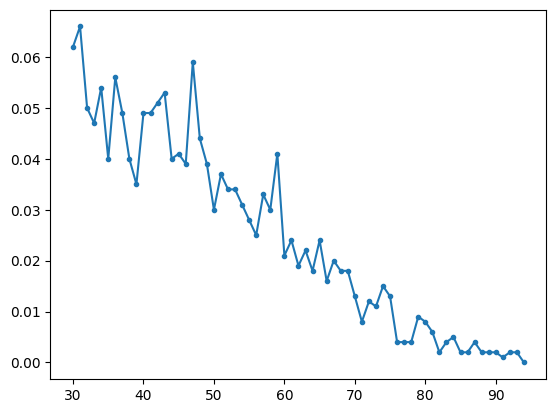

In [112]:
import matplotlib.pyplot as plt

plt.plot(seq_lens, validities, marker='.')

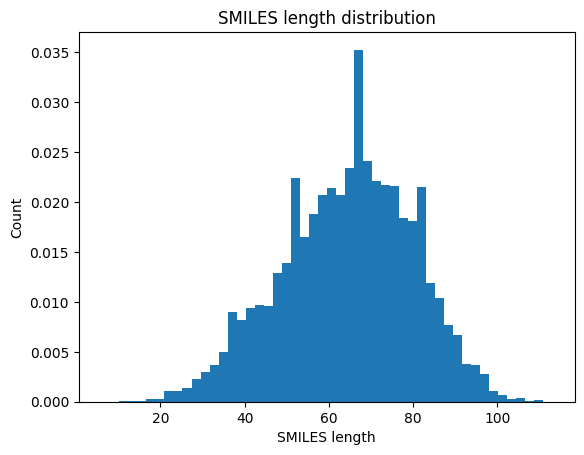

In [113]:
plt.hist(lengths, bins=50, density=True)
plt.xlabel("SMILES length")
plt.ylabel("Count")
plt.title("SMILES length distribution")
plt.show()

perturb existing molecules

In [114]:
from torch.utils.data import DataLoader, SubsetRandomSampler

In [115]:
batch_size = 1000

random_indices = np.random.choice(dataset_indices, size=n_samples, replace=False)

sampler = SubsetRandomSampler(random_indices)

loader = DataLoader(dataset, batch_size=n_samples, sampler=sampler)

print(n_samples)

1000


In [137]:
perturb = lambda x: x + 0.05

In [138]:
gen_smiles_list = []
valid_idxs = []
for i, idx in enumerate(random_indices):
    node_mat = dataset[idx][0][0].unsqueeze(0)
    adj_mat = dataset[idx][0][1].unsqueeze(0)

    smiles = smiles_to_idxs([dataset[idx][2]], token2idx, DEVICE)

    gap = dataset[idx][1]
    perturbed_gap = torch.as_tensor(list(map(perturb, gap))).unsqueeze(0)

    model_inputs = (node_mat, adj_mat, smiles, perturbed_gap)

    model(*model_inputs)
    mu = model.z_mean
    logvar = model.z_logvar
    sigma = torch.exp(0.5 * logvar)

    z = mu + sigma * torch.randn_like(sigma)

    with torch.no_grad():
        token_seq = model.sample(z, perturbed_gap, seq_length=smiles.size()[-1]).squeeze(0)

    gen_smiles = "".join(map(convert, token_seq))
    gen_smiles_list.append(gen_smiles)    

valid_smiles, valid_mols, valid_idxs = filter_valid_smiles(gen_smiles_list)

validity = len(valid_smiles)/len(gen_smiles_list)
validities.append(validity)
print(f"Validity: {validity}")
    

Validity: 0.016


In [139]:
print(valid_smiles)
print(gen_smiles_list)

print(valid_idxs)

['[H]C(=O)C(=O)[C@@]([H])(C([H])([H])[H])C', '[H]C([H])([H])[C@@]([H])(C([H])([H])[H])', '[H]C(=O)[C@@]2([H])O[C@]2(C([H])([H])[H])', '[H][N-]C([H])([H])OC([H])([H])C([H])([H])C([H])([H])CC', '[H]C([H])(C([H])([H])[C@@]([H])(C([H])([H])[H])C(=O)C([H])([H])[H])C([H])([H])[C@@]', '[H]O[C@@]2(C([H])([H])[H])[C@@]1([H])C([H])([H])OC([H])([H])[C@@]21C', '[H]C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])O[C@]1([H])O[C@@]', '[H]C(=O)C(=O)[C@]1([H])C([H])([H])[C@]1([H])OC', '[H]O[C@]1(N([H])[H])C([H])([H])[C@@]1([H])C([H])', '[H]OC([H])([H])[C@]1([H])OC(=O)C1([H])C([H])', '[H]O[C@@]1(C([H])([H])[H])C([H])([H])C([H])([H])[C@]1([H])[C@]', '[H]C1([H])O[C@@]2([H])C([H])([H])O[C@]2([H])[C@]([H])(C([H])([H])[H])C1([H])[H]', '[H]C1=NC(C([H])([H])C([H])([H])N1[H])[C@]', '[H]C1([H])[C@@]2([H])[C@]1([H])[C@@]12C([H])([H])[C@]1', '[H]C(=O)C(=O)N1C(=O)[C@]1([H])C([H])([H])', '[H]N([H])[C@]12N([H])[C@@]([H])(OC([H])([H])[H])[N@H+]2C([H])([H])C1([H])']
['[H][C-]1[C@@]1([H])[C@]2([H])O[C@@]1(

In [140]:
for (idx, gen_smiles) in zip(valid_idxs, valid_smiles):
    original_smiles = dataset[idx][2]
    print(f"Start SMILES: {original_smiles} -> {gen_smiles}")

    mol1 = Chem.MolFromSmiles(original_smiles)
    mol2 = Chem.MolFromSmiles(gen_smiles)

    img1 = Chem.Draw.MolToImage(mol1, size=(300, 300))
    img2 = Chem.Draw.MolToImage(mol2, size=(300, 300))

    img1
    img2

Start SMILES: [H]C([H])([H])C([H])([H])C1([H])C([H])([H])C1([H])[H] -> [H]C(=O)C(=O)[C@@]([H])(C([H])([H])[H])C
Start SMILES: [H]C1=NN=C([H])O1 -> [H]C([H])([H])[C@@]([H])(C([H])([H])[H])
Start SMILES: [H]C1=C([H])N([H])C(=O)N1[H] -> [H]C(=O)[C@@]2([H])O[C@]2(C([H])([H])[H])
Start SMILES: [H]C1=C([H])OC(=O)O1 -> [H][N-]C([H])([H])OC([H])([H])C([H])([H])C([H])([H])CC
Start SMILES: [H]N(C(=O)C([H])([H])[H])C([H])([H])C([H])([H])[H] -> [H]C([H])(C([H])([H])[C@@]([H])(C([H])([H])[H])C(=O)C([H])([H])[H])C([H])([H])[C@@]
Start SMILES: [H]O[C@@]([H])(C(=O)C([H])([H])[H])C([H])([H])[H] -> [H]O[C@@]2(C([H])([H])[H])[C@@]1([H])C([H])([H])OC([H])([H])[C@@]21C
Start SMILES: [H]C([H])([H])C1(C([H])([H])[H])C([H])([H])C([H])([H])C1([H])[H] -> [H]C1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])O[C@]1([H])O[C@@]
Start SMILES: [H]C(=O)[C@]1([H])N([H])[C@]1([H])C([H])([H])[H] -> [H]C(=O)C(=O)[C@]1([H])C([H])([H])[C@]1([H])OC
Start SMILES: [H]C1([H])OC([H])([H])C12OC2([H])[H] -> [H]O[C@]1(N

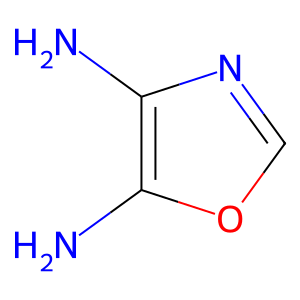

In [162]:
mol1 = Chem.MolFromSmiles(dataset[944][2])

img1 = Chem.Draw.MolToImage(mol1, size=(300, 300))
img1

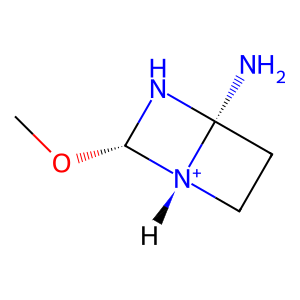

In [161]:
mol2 = Chem.MolFromSmiles(valid_smiles[15])

img2 = Chem.Draw.MolToImage(mol2, size=(300, 300))
img2